# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
#1- Download this file manually by clicking the following link: twitter_archive_enhanced.csv : done
#2 -  using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
import requests
import os
import numpy as np
import pandas as pd
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline





2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:

#url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#response = requests.get(url)
#open(r'C:\Users\to108931\Documents\01- Project\NanoDegree\Wrangling Project\image_prediction.tsv', mode='wb').write(response.content)
        

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)


#3.1  get the tweet IDs from Weratedogs
#The general idea is to loop on the tweet_id columb to query the twitter api using those values
df = pd.read_csv(r'C:\Users\to108931\Documents\01- Project\NanoDegree\Wrangling Project\twitter-archive-enhanced.csv')
df['tweet_id'].head()

#twitter authent
client = tweepy.Client(
    consumer_key="API / Consumer Key here",
    consumer_secret="API / Consumer Secret here",
    access_token="Access Token here",
    access_token_secret="Access Token Secret here"
)

# Since I don't want to create a twitter account, I got the twitter API code from the ressources & the tweet_json.txt file
import tweepy
from tweepy import OAuthHandler
import json 
from timeit import default_timer as timer 
#Query Twitter API for each tweet in the Twitter archive and save JSON in a text file 
#These are hidden to comply with Twitter's API terms and conditions 
consumer_key = 'HIDDEN' 
consumer_secret = 'HIDDEN' 
access_token = 'HIDDEN' 
access_secret = 'HIDDEN' 
auth = OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_secret) 
api = tweepy.API(auth, wait_on_rate_limit=True) 
#NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES: 
#df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to 
#change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv 
#NOTE TO REVIEWER: this student had mobile verification issues so the following 
#Twitter API code was sent to this student from a Udacity instructor 
#Tweet IDs for which to gather additional data via Twitter's API 
tweet_ids = df_1.tweet_id.values 
len(tweet_ids) 
#Query Twitter's API for JSON data for each tweet ID in the Twitter 
archive count = 0 
fails_dict = {} 
start = timer() 
#Save each tweet's returned JSON as a new line in a .txt file 
with open('tweet_json.txt', 'w') as outfile: 
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit 
    #we loop on the tweet_id column
    for tweet_id in tweet_ids: 
        #we pass to the following value
        count += 1 
        print(str(count) + ": " + str(tweet_id)) 
        try: tweet = api.get_status(tweet_id, tweet_mode='extended') 
            print("Success") 
            json.dump(tweet._json, outfile) 
            outfile.write('\n') 
        except tweepy.TweepError as e: 
            print("Fail") 
            fails_dict[tweet_id] = e 
            pass end = timer()
        print(end - start) 
        print(fails_dict)


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [3]:
df = pd.read_csv(r'twitter-archive-enhanced.csv')

image = pd.read_csv("image_prediction.tsv",sep='\t')

image[image.p1_dog == False][image.p2_dog == False ][image.p3_dog == False ]

df[df.retweeted_status_id.notna()]
#df.rating_denominator.unique()
#df[df.rating_denominator == 50]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [4]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
df.rating_numerator.unique()


array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [6]:
df[df.rating_numerator == 60]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None


In [7]:
tweet_json = []
for line in open('tweet-json.txt', 'r'):
    tweet_json.append(json.loads(line))
    
df_json = pd.DataFrame(tweet_json)
df_json.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,False,False,en,NaN,NaN,NaN,NaN


In [8]:
df_json.lang.value_counts()

en     2336
und       7
in        3
nl        3
et        1
ro        1
eu        1
es        1
tl        1
Name: lang, dtype: int64

### Quality issues
1. Programatic: some lines have retweet id & status at not null, those lines can be removes

2. visual : retweet column can be removed,  in the json df there are two columns with the tweet id (id & id_str) ,  In json df we can remove all unnecessary columns regarding retweet 

3. programatic: in df  Programatic : using info, we see that the image_prediction contains 2075 rows, whereas twitter archive has 2356; so around 180 tweets have no picture - after cleaning the retweets we will se what remains

4. programatic: df.rating_denominator.unique() : shows that some denominators are not 10 (0, 15,...)

5. Retweets and Favorite Count: retweet_count and favorite_count should be integers, not floats.

6. in df, timestamp is an object type and there are "+0000" at the end of every timestamp

7. in the twitter archive around 53 dogs have the name "a", "an, "all", "by", "infuriating", "such", "officially", "one" - which maybe a mistake (rq: all are starting with lower case where proper doggo names are higher case)

8. ID fields: The ID fields, like tweet_id, in_reply_to_status_id etc. should be objects, not integers or floats because they are not numeric and aren't intended to perform calculations.

9. some tweets are not doggos, we will remove them

### Tidiness issues
1. type can be in a unique column with the actual dogo type in it

2. df & json_df should be joined in a unique DF by tweet id (then quality issues will follow with duplicated columns)

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [9]:
# Make copies of original pieces of data
df_clean =df.copy()
json_df_clean = df_json.copy()
image_clean = image.copy()


### Issue 1: visual: retweeted parameters can be dropped

#### row with values in retweeted_status_id & retweeted_status_user  & timestamp can be dropped

#### Code

In [10]:
to_drop =df_clean[df_clean.retweeted_status_id.notna()]['tweet_id']
to_drop
index_to_drop = []
df_clean.drop(to_drop.index, inplace= True)
df_clean.index = range(len(df_clean))


In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### Test

In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Issue 2: retweeted status column can be removed

#### DefineWe  remove theretweeted_status_id          retweeted_status_user_id  retweeted_status_timestamp 

#### Code

In [13]:
df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id' ,'retweeted_status_timestamp'],axis=1, inplace= True)

#### Test

In [14]:

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 238.0+ KB


### in the json df there are two columns with the tweet id (id & id_str)


#### Define : we will remove the id_str from the json_df

#### Code

In [15]:
json_df_clean.drop("id_str", axis =1, inplace = True)

#### Test

In [16]:
json_df_clean.head()

,created_at,id,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,41048,False,False,False,False,en,NaN,NaN,NaN,NaN


### In the  json df we can remove all unnecessary columns regarding retweet 

#### Define : we will remove unnecessary columns from the json_df

#### Code

In [17]:
json_df_clean.dtypes

created_at                        object
id                                 int64
full_text                         object
truncated                           bool
display_text_range                object
entities                          object
extended_entities                 object
source                            object
in_reply_to_status_id            float64
in_reply_to_status_id_str         object
in_reply_to_user_id              float64
in_reply_to_user_id_str           object
in_reply_to_screen_name           object
user                              object
geo                               object
coordinates                       object
place                             object
contributors                      object
is_quote_status                     bool
retweet_count                      int64
favorite_count                     int64
favorited                           bool
retweeted                           bool
possibly_sensitive                object
possibly_sensiti

In [18]:
json_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id','in_reply_to_user_id_str', 'in_reply_to_screen_name', 'is_quote_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status', 'retweeted_status'], axis =1, inplace = True)

#### Test

In [19]:
json_df_clean.dtypes

created_at                       object
id                                int64
full_text                        object
truncated                          bool
display_text_range               object
entities                         object
extended_entities                object
source                           object
user                             object
geo                              object
coordinates                      object
place                            object
contributors                     object
retweet_count                     int64
favorite_count                    int64
favorited                          bool
retweeted                          bool
possibly_sensitive               object
possibly_sensitive_appealable    object
lang                             object
dtype: object

### Issue 3: Programatic : using info, we see that the image_prediction contains 2075 rows, whereas twitter archive has 2356; so around 180 tweets have no images

#### Define we will remove the tweets in merge that don't appear in image_clean

#### Code

In [20]:
to_remove = []
for i in range(1, len(df_clean)):
    exists = df_clean.tweet_id[i]
    if (image_clean['tweet_id'] == exists).any():
        pass
    else:
       to_remove.append(df_clean.tweet_id[i])
       df_clean.drop(df_clean[df_clean['tweet_id'] == exists].index, inplace= True)
#visual assement for the test : we display the to remove array and check for some sample (for testing while coding purpose)
to_remove




[886267009285017600,
 885518971528720385,
 884247878851493888,
 881633300179243008,
 879674319642796034,
 878604707211726852,
 876537666061221889,
 875097192612077568,
 871102520638267392,
 870726314365509632,
 866720684873056260,
 863427515083354112,
 857214891891077121,
 856288084350160898,
 855862651834028034,
 855860136149123072,
 855857698524602368,
 855818117272018944,
 850333567704068097,
 848213670039564288,
 847617282490613760,
 846505985330044928,
 846139713627017216,
 843981021012017153,
 841320156043304961,
 840698636975636481,
 838952994649550848,
 838150277551247360,
 838085839343206401,
 835246439529840640,
 834089966724603904,
 832682457690300417,
 832645525019123713,
 832088576586297345,
 831926988323639298,
 828361771580813312,
 826598799820865537,
 824025158776213504,
 823333489516937216,
 821153421864615936,
 819238181065359361,
 817908911860748288,
 813130366689148928,
 811647686436880384,
 808344865868283904,
 806576416489959424,
 804475857670639616,
 802600418706

#### Test

In [21]:
image_clean[image_clean['tweet_id'] == 876537666061221889]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [22]:
df_clean[df_clean['tweet_id'] == 876537666061221889]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [23]:
#by sampling the values in to_remove with image_clean, we confirm the list is correct
df_clean.index = range(len(df_clean))
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 218.2+ KB


### Issue 4:  programatic: df.rating_denominator.unique() : shows that some denominators are not 10 (0, 15,...)

#### Define the idea is to have a ccommon denominator for all dogs and adapting the numerator accordingly


#### Code

In [24]:
df_clean.rating_denominator.value_counts()
#For the tweets where it shows many dogs (thus having x time 10 as denominator) we will calculate the mean score of the doggos

10     1976
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [25]:
df_clean2 = df_clean.copy()
factor = np.empty(len(df_clean2), dtype=float)


for i in range (0, len(df_clean2)):
    factor[i] = df_clean2.rating_denominator[i]/10
    if factor[i] != 0:
        df_clean2.rating_numerator[i] = (df_clean2.rating_numerator[i]/factor[i])
        df_clean2.rating_denominator[i] = 10



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


##### TEST

In [26]:
df_clean.rating_denominator.value_counts()


10     1976
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [27]:
#some sample tests by hand on some specific values
df_clean2[df_clean2['tweet_id'] == 704054845121142784]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1054,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,12,10,a,None,None,None,None


In [28]:
df_clean2.rating_denominator.value_counts()
df_clean.rating_denominator.value_counts()

10     1976
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [29]:
check = []
for i in range (0, len(df_clean2)):
    if df_clean.rating_denominator[i] != 10:
        check.append((df_clean.rating_numerator[i]/df_clean.rating_denominator[i]) / (df_clean2.rating_numerator[i]/df_clean2.rating_denominator[i]))
#all value in check shall be 1
check
#we see some values close to 1 and not exactly 1 because we go from int to float to int with the factor division - so some approx are done
#we take df_clean2 as the new baseline
df_clean = df_clean2.copy()

In [30]:
df_clean[df_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
39,This is Bella. She hopes her smile made you sm...,5
503,"This is Logan, the Chow who lived. He solemnly...",75
553,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1374,Here we have uncovered an entire battalion of ...,26


### Issue 5: Retweets and Favorite Count: retweet_count and favorite_count should be integers, not floats.

#### Define: we will put the retweets & fav cuonts in integer

#### Code

In [31]:
json_df_clean['retweet_count']= json_df_clean['retweet_count'].astype(int)
json_df_clean['favorite_count']= json_df_clean['favorite_count'].astype(int)

#### Test

In [32]:
json_df_clean.dtypes

created_at                       object
id                                int64
full_text                        object
truncated                          bool
display_text_range               object
entities                         object
extended_entities                object
source                           object
user                             object
geo                              object
coordinates                      object
place                            object
contributors                     object
retweet_count                     int32
favorite_count                    int32
favorited                          bool
retweeted                          bool
possibly_sensitive               object
possibly_sensitive_appealable    object
lang                             object
dtype: object

### Issue 6: in df, timestamp is an object type and there are "+0000" at the end of every timestamp

#### Define: we will put the timestamp in a proper format (YYYY-MM-DD HH-MM-SS)

#### Code

In [33]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

#### Test

In [34]:
df_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                datetime64[ns, UTC]
source                                object
text                                  object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
dtype: object

In [35]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue 7: in the twitter archive around 53 dogs have the name "a", "an, "all", "by", "infuriating", "such", "officially", "one" - which maybe a mistake (rq: all are starting with lower case where proper doggo names are higher case)


#### Define: we will remove all tweet where the doggo name is incorrect
what we observed with the excel file is that all wrong doggo names start with a lower case letter whereas the proper doggo names start with upper case. we will use this to remove the invalid rows

#### Code

In [36]:
# we see that the lower case "rule" is correct, so we can remove all those rwas based on this rule
df_clean[df_clean.name.str[0].str.islower()].name.value_counts()

a               55
the              7
an               6
one              4
very             4
quite            3
just             3
getting          2
actually         1
by               1
space            1
this             1
his              1
unacceptable     1
my               1
officially       1
not              1
light            1
infuriating      1
such             1
incredibly       1
all              1
Name: name, dtype: int64

In [37]:
to_remove = df_clean[df_clean.name.str[0].str.islower()].index
to_remove

Int64Index([  21,   49,  135,  149,  275,  404,  472,  582,  596,  622,  681,
             734,  738,  739,  746,  748,  757,  762,  768,  783,  795,  803,
             826,  848,  849,  866,  919,  929,  973, 1045, 1054, 1064, 1065,
            1070, 1082, 1085, 1132, 1150, 1185, 1209, 1275, 1356, 1386, 1398,
            1407, 1441, 1452, 1469, 1503, 1504, 1527, 1528, 1569, 1582, 1586,
            1600, 1639, 1646, 1664, 1675, 1679, 1682, 1710, 1760, 1769, 1772,
            1790, 1796, 1804, 1833, 1840, 1846, 1853, 1859, 1863, 1876, 1890,
            1896, 1903, 1912, 1926, 1942, 1949, 1952, 1964, 1965, 1971, 1972,
            1973, 1983, 1984, 1985, 1986, 1987, 1988, 1990, 1991, 1992],
           dtype='int64')

In [38]:
df_clean.drop(to_remove, inplace = True)
        
    



#### Test

In [39]:
df_clean[df_clean.name.str[0].str.islower()].name.value_counts() 

Series([], Name: name, dtype: int64)

### Issue 8: ID fields: The ID fields, like tweet_id, in_reply_to_status_id etc. should be objects, not integers or floats because they are not numeric and aren't intended to perform calculations.

#### Define: we will put the timestamp in a proper format (YYYY-MM-DD HH-MM-SS)

#### Code

In [40]:
df_clean['tweet_id']= df_clean['tweet_id'].astype(str)
json_df_clean['id']= json_df_clean['id'].astype(str)
image_clean['tweet_id']= image_clean['tweet_id'].astype(str)

df_clean['in_reply_to_status_id']=df_clean['in_reply_to_status_id'].astype(object)
df_clean['in_reply_to_status_id']= df_clean['in_reply_to_status_id'].astype(object)

#### Test

In [41]:
df_clean.dtypes


tweet_id                              object
in_reply_to_status_id                 object
in_reply_to_user_id                  float64
timestamp                datetime64[ns, UTC]
source                                object
text                                  object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
dtype: object

### Issue #9: 9. some tweets are not doggos, we will remove them

#### Define: we will remove all the lines in the dataframe that are not actual dog breed from the image df

In [42]:
image_clean[image_clean.p1_dog == False][image_clean.p2_dog == False ][image_clean.p3_dog == False ]

not_doggo = image_clean[image_clean.p1_dog == False][image_clean.p2_dog == False ][image_clean.p3_dog == False ]['tweet_id']
not_doggo.reset_index(drop=True, inplace=True)
not_doggo
df_clean = df_clean[~df_clean['tweet_id'].isin(not_doggo)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until



### Issue #1: merging the tables

#### Define: df & json_df can be merged in a unique dataframe using the tweet id as a key

#### Code

In [43]:
#firt we need to rename the column id from the json_df to tweet_id
json_df_clean.rename(columns={"id": "tweet_id"}, inplace = True)
merge_df = pd.merge(df_clean, json_df_clean, on=['tweet_id'], how ='left')


#### Test

In [44]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 33 columns):
tweet_id                         1606 non-null object
in_reply_to_status_id            20 non-null object
in_reply_to_user_id              20 non-null float64
timestamp                        1606 non-null datetime64[ns, UTC]
source_x                         1606 non-null object
text                             1606 non-null object
expanded_urls                    1606 non-null object
rating_numerator                 1606 non-null int64
rating_denominator               1606 non-null int64
name                             1606 non-null object
doggo                            1606 non-null object
floofer                          1606 non-null object
pupper                           1606 non-null object
puppo                            1606 non-null object
created_at                       1606 non-null object
full_text                        1606 non-null object
truncated            

### Issue #2: type can be in a unique column with the actual dogo type in it
and we will also clean a little bit the merge_df by removing some useless columns

#### Define: dogo type is spread amongst 4 different columns (doggo, fluffer, pupper & puppo), we will merge those 4 columns into a unique one called : dogo_type

#### Code

In [45]:
merge_df.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis =1, inplace = True)
#'in_reply_to_status_id_y','in_reply_to_status_id_str','in_reply_to_user_id_y', 'in_reply_to_user_id_str','in_reply_to_screen_name'], axis =1, inplace = True)
merge_df.doggo.replace("None",'', inplace = True)
merge_df.floofer.replace("None",'', inplace = True)
merge_df.pupper.replace("None",'', inplace = True)
merge_df.puppo.replace("None",'', inplace = True)
merge_df['doggo_type'] = merge_df.doggo + merge_df.floofer + merge_df.pupper + merge_df.puppo
merge_df.doggo_type.value_counts()
#some dogs have several types  -doggo pupper, doggopuppo & doggofloofer
#we will all the values but re-write to be leasible (having a '&' inbeteween)

merge_df.loc[merge_df.doggo_type == 'doggopupper', 'doggo_type'] = 'doggo & pupper'
merge_df.loc[merge_df.doggo_type == 'doggofloofer', 'doggo_type'] = 'doggo & flooffer'
merge_df.loc[merge_df.doggo_type == 'doggopuppo', 'doggo_type'] = 'doggo & puppo'


In [46]:
merge_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace = True)

#### Test

In [47]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 28 columns):
tweet_id                         1606 non-null object
timestamp                        1606 non-null datetime64[ns, UTC]
source_x                         1606 non-null object
text                             1606 non-null object
expanded_urls                    1606 non-null object
rating_numerator                 1606 non-null int64
rating_denominator               1606 non-null int64
name                             1606 non-null object
created_at                       1606 non-null object
full_text                        1606 non-null object
truncated                        1606 non-null bool
display_text_range               1606 non-null object
entities                         1606 non-null object
extended_entities                1606 non-null object
source_y                         1606 non-null object
user                             1606 non-null object
geo                 

In [48]:
merge_df.doggo_type.value_counts()

                    1356
pupper               159
doggo                 54
puppo                 21
doggo & pupper         7
floofer                7
doggo & flooffer       1
doggo & puppo          1
Name: doggo_type, dtype: int64

In [49]:
master_merge = pd.merge(merge_df, image_clean, on=['tweet_id'], how ='left')
master_merge.head()

,tweet_id,timestamp,source_x,text,expanded_urls,rating_numerator,rating_denominator,name,created_at,full_text,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Tue Aug 01 00:17:27 +0000 2017,This is Tilly. She's just checking pup on you....,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Mon Jul 31 00:18:03 +0000 2017,This is Archie. He is a rare Norwegian Pouncin...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Sun Jul 30 15:58:51 +0000 2017,This is Darla. She commenced a snooze mid meal...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
3,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Sat Jul 29 16:00:24 +0000 2017,This is Franklin. He would like you to stop ca...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
4,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,Sat Jul 29 00:08:17 +0000 2017,Here we have a majestic great white breaching ...,...,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [50]:
master_merge.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [51]:
doggof = pd.read_csv('twitter_archive_master.csv')
doggof.head()

,tweet_id,timestamp,source_x,text,expanded_urls,rating_numerator,rating_denominator,name,created_at,full_text,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Tue Aug 01 00:17:27 +0000 2017,This is Tilly. She's just checking pup on you....,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Mon Jul 31 00:18:03 +0000 2017,This is Archie. He is a rare Norwegian Pouncin...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Sun Jul 30 15:58:51 +0000 2017,This is Darla. She commenced a snooze mid meal...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
3,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Sat Jul 29 16:00:24 +0000 2017,This is Franklin. He would like you to stop ca...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
4,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,Sat Jul 29 00:08:17 +0000 2017,Here we have a majestic great white breaching ...,...,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False


In [52]:
doggof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 39 columns):
tweet_id                         1606 non-null int64
timestamp                        1606 non-null object
source_x                         1606 non-null object
text                             1606 non-null object
expanded_urls                    1606 non-null object
rating_numerator                 1606 non-null int64
rating_denominator               1606 non-null int64
name                             1606 non-null object
created_at                       1606 non-null object
full_text                        1606 non-null object
truncated                        1606 non-null bool
display_text_range               1606 non-null object
entities                         1606 non-null object
extended_entities                1606 non-null object
source_y                         1606 non-null object
user                             1606 non-null object
geo                              0

### Insights:
0. we will a first re-wrangling step here, where we will merge all p1, p2, p3 into one colomn: breed: absed on the first "true" proba & the associated breed

1. we will see what are the most represented breeds

2. we will see the average ratings for the 10 top breeds

3. we will see what are the more retweeted of the 10 top breeds - that would give a global appreciation of the success of the given breed (by calculating the average retweet for 1 tweet)

In [53]:
doggof['breed'] = pd.NaT
for i in range (0, len(doggof)):
    if(doggof['p1_dog'][i]):
        doggof['breed'][i] =  doggof['p1'][i]
    elif(doggof['p2_dog'][i]):
        doggof['breed'][i] = doggof['p2'][i]
    elif (doggof['p3_dog'][i]):
        doggof['breed'][i] = doggof['p3'][i]

#we will remove the  useless colomn
doggof.drop(['p1', 'p2','p3','p1_dog', 'p2_dog','p3_dog','p1_conf', 'p2_conf','p3_conf'], axis =1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData

In [54]:
n =10
breeds = doggof['breed'].value_counts()[:n].index.tolist()
breeds
#doggof[doggof['breed'] =="French_bulldog"].info()

['golden_retriever',
 'Labrador_retriever',
 'Pembroke',
 'Chihuahua',
 'pug',
 'toy_poodle',
 'chow',
 'Samoyed',
 'Pomeranian',
 'malamute']

### TOP 10 BREEDS OF WE RATE DOGS: 'golden_retriever',
 'Labrador_retriever'
 'Pembroke',
 'Chihuahua',
 'pug',
 'toy_poodle',
 'chow',
 'Samoyed',
 'Pomeranian',
 'French_bulldog'
 
 French Bulldog having 31 entries, we will continue the insight based on the 10 first breeds

In [55]:
mean_breed = []
for i in range (0, len(breeds)):
    mean_breed.append(doggof[doggof['breed'] ==breeds[i]].rating_numerator.mean())



In [56]:
mean_retweet = []
for i in range (0, len(breeds)):
    mean_retweet.append(doggof[doggof['breed'] ==breeds[i]].retweet_count.mean())

mean_fav =[]
for i in range (0, len(breeds)):
    mean_fav.append(doggof[doggof['breed'] ==breeds[i]].favorite_count.mean())
    
mean_fav

[12608.328947368422,
 11959.657142857142,
 10977.384615384615,
 8359.988764044943,
 6468.017241379311,
 7157.765957446809,
 9719.711111111112,
 13314.15,
 7796.5641025641025,
 8303.645161290322]

In [57]:
mean_rating = {"Breeds": breeds, "Mean_rating": mean_breed, "Mean_Retweet": mean_retweet, "Mean_Fav": mean_fav}
mean_rating_df = pd.DataFrame(mean_rating)
mean_rating_df

,Breeds,Mean_rating,Mean_Retweet,Mean_Fav
0,golden_retriever,11.684211,3807.657895,12608.328947
1,Labrador_retriever,11.257143,3823.390476,11959.657143
2,Pembroke,11.483516,3095.450549,10977.384615
3,Chihuahua,10.539326,2817.000000,8359.988764
4,pug,10.275862,1992.948276,6468.017241
5,toy_poodle,11.063830,2443.404255,7157.765957
6,chow,11.466667,2864.577778,9719.711111
7,Samoyed,11.650000,4662.750000,13314.150000
8,Pomeranian,12.538462,2795.435897,7796.564103
9,malamute,10.903226,2476.387097,8303.645161


French bulldog seem to have the more success regarding retweet and Favorite count!

### Visualization

Text(0.5, 1.0, 'Mean Favorites & retweets per breeds')

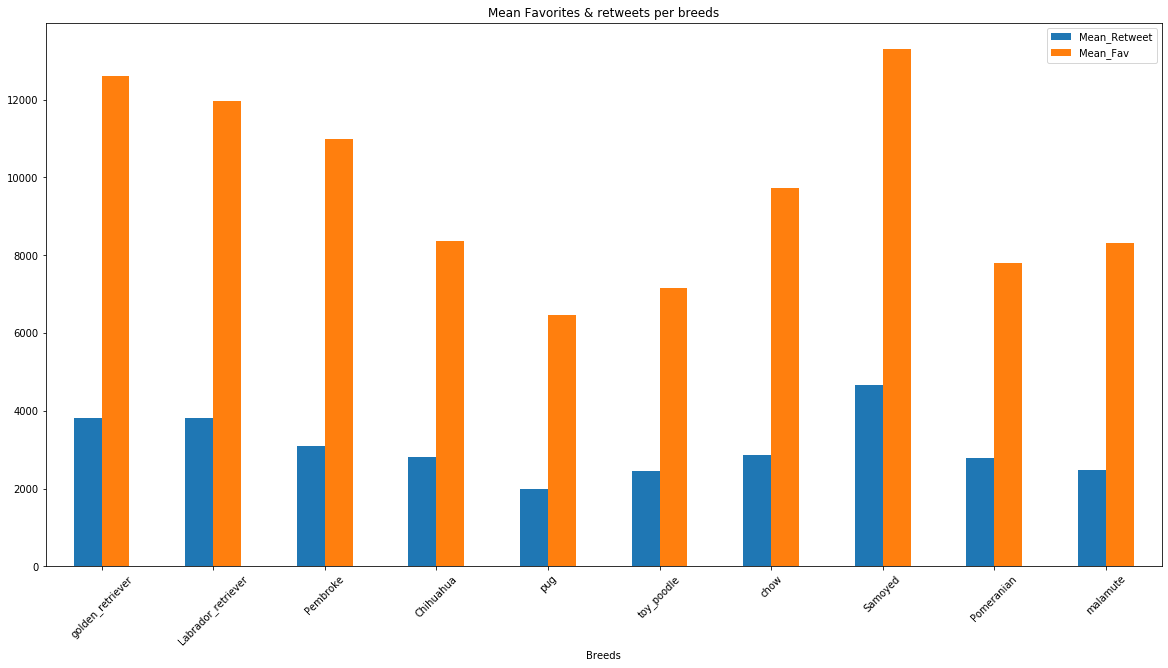

In [61]:
mean_retweet_fav = mean_rating_df.drop(['Mean_rating'], axis= 1)
mean_retweet_fav.index = breeds
plot = mean_retweet_fav.plot.bar(rot=45,figsize=(20,10))
plot.set_xlabel("Breeds")
plot.set_title("Mean Favorites & retweets per breeds")
